<a href="https://colab.research.google.com/github/ykato27/Image-Classification/blob/main/SSD_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SSD(Single Shot MultiBox Detector)
物体検出に主に使用されるモデル

### モデルを取得
学習済みモデルを取得

In [1]:
import torch


precision = "fp32"
ssd_model = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub", "nvidia_ssd", model_math=precision
)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [2]:
# 前処理や後処理を使用できる共通関数を取得
utils = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub", "nvidia_ssd_processing_utils"
)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [3]:
# batchnormとdropoutレイヤーをevalモードにするため、model.evalを使用
ssd_model.to("cuda")
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

### データの前処理
画像データを取得するためのリンクのリストを作成

In [4]:
uris = [
    "http://images.cocodataset.org/val2017/000000397133.jpg",
    "http://images.cocodataset.org/val2017/000000037777.jpg",
    "http://images.cocodataset.org/val2017/000000252219.jpg",
]

In [5]:
# 画像データを前処理してPyTorchで処理しやすいTensor形式に
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == "fp16")

### 物体検出処理 
torch.no_grad()でautogradエンジンをオフにしてメモリの使用量を減らし、計算速度を向上させてから推論処理

In [6]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

### データの後処理
SSDで処理した結果の後処理をします。大量の検出結果が発生するので一定の閾値以上の値のみ採用

In [7]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [
    utils.pick_best(results, 0.5) for results in results_per_input
]

In [8]:
# クラス情報は数値情報なのでラベル情報に変換するための処理
classes_to_labels = utils.get_coco_object_dictionary()

### 結果の確認
物体検出した結果を確認するための処理

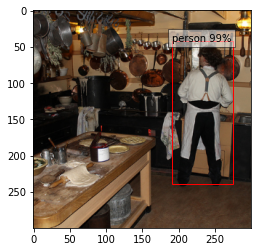

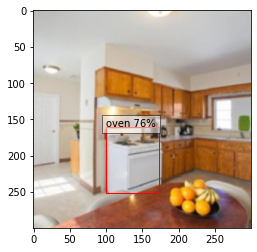

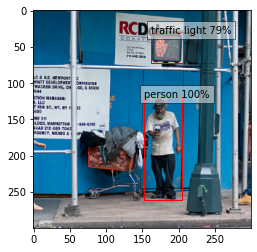

In [9]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches


for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [
            val * 300 for val in [left, bot, right - left, top - bot]
        ]
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=1, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x,
            y,
            "{} {:.0f}%".format(
                classes_to_labels[classes[idx] - 1], confidences[idx] * 100
            ),
            bbox=dict(facecolor="white", alpha=0.5),
        )
plt.show()